### Import necessary packages

In [2]:
import numpy as np
import pandas as pd
# import sklearn
# import lightgbm as lgb
import shap
import xgboost
# import tensorflow as tf
from sklearn.datasets import fetch_california_housing, load_diabetes
from sklearn.model_selection import train_test_split


c:\Users\Lulock\anaconda3\envs\xai\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.


In [13]:
# 0 -> california dataset
# 1 -> diabetes dataset
# default -> california dataset
def load_data( ds_id ):
    data = False
    match ds_id:
        case 0:
            data = fetch_california_housing()
        case 1:
            data = load_diabetes()
        case _:
            data = fetch_california_housing() # default is california housing
    
    print(data.DESCR)
    return data

def prep_dataframe( ds ):
    X = ds.data
    y = ds.target 
    ds_features = ds.feature_names


    df = pd.concat((pd.DataFrame(X, columns = ds_features ),
                        pd.DataFrame({'Target': y})), axis=1)
    
    return X, y, ds_features, df

### California Housing Dataset 

In [27]:
cal_data = load_data( 0 )
X, y, features, cal_df = prep_dataframe( cal_data )
print(cal_df)
cal_df.head()

.. _california_housing_dataset:

California Housing dataset
--------------------------

**Data Set Characteristics:**

    :Number of Instances: 20640

    :Number of Attributes: 8 numeric, predictive attributes and the target

    :Attribute Information:
        - MedInc        median income in block group
        - HouseAge      median house age in block group
        - AveRooms      average number of rooms per household
        - AveBedrms     average number of bedrooms per household
        - Population    block group population
        - AveOccup      average number of household members
        - Latitude      block group latitude
        - Longitude     block group longitude

    :Missing Attribute Values: None

This dataset was obtained from the StatLib repository.
https://www.dcc.fc.up.pt/~ltorgo/Regression/cal_housing.html

The target variable is the median house value for California districts,
expressed in hundreds of thousands of dollars ($100,000).

This dataset was derived

MedInc  HouseAge  AveRooms  AveBedrms  Population  AveOccup  Latitude  \
0  8.3252      41.0  6.984127   1.023810       322.0  2.555556     37.88   
1  8.3014      21.0  6.238137   0.971880      2401.0  2.109842     37.86   
2  7.2574      52.0  8.288136   1.073446       496.0  2.802260     37.85   
3  5.6431      52.0  5.817352   1.073059       558.0  2.547945     37.85   
4  3.8462      52.0  6.281853   1.081081       565.0  2.181467     37.85   

   Longitude  Target  
0    -122.23   4.526  
1    -122.22   3.585  
2    -122.24   3.521  
3    -122.25   3.413  
4    -122.25   3.422

In [15]:
diab_data = load_data( 1 )
X, y, features, diab_df = prep_dataframe( diab_data )
print(diab_df)
diab_df.head()

.. _diabetes_dataset:

Diabetes dataset
----------------

Ten baseline variables, age, sex, body mass index, average blood
pressure, and six blood serum measurements were obtained for each of n =
442 diabetes patients, as well as the response of interest, a
quantitative measure of disease progression one year after baseline.

**Data Set Characteristics:**

  :Number of Instances: 442

  :Number of Attributes: First 10 columns are numeric predictive values

  :Target: Column 11 is a quantitative measure of disease progression one year after baseline

  :Attribute Information:
      - age     age in years
      - sex
      - bmi     body mass index
      - bp      average blood pressure
      - s1      tc, total serum cholesterol
      - s2      ldl, low-density lipoproteins
      - s3      hdl, high-density lipoproteins
      - s4      tch, total cholesterol / HDL
      - s5      ltg, possibly log of serum triglycerides level
      - s6      glu, blood sugar level

Note: Each of these 1

age       sex       bmi        bp        s1        s2        s3  \
0  0.038076  0.050680  0.061696  0.021872 -0.044223 -0.034821 -0.043401   
1 -0.001882 -0.044642 -0.051474 -0.026328 -0.008449 -0.019163  0.074412   
2  0.085299  0.050680  0.044451 -0.005670 -0.045599 -0.034194 -0.032356   
3 -0.089063 -0.044642 -0.011595 -0.036656  0.012191  0.024991 -0.036038   
4  0.005383 -0.044642 -0.036385  0.021872  0.003935  0.015596  0.008142   

         s4        s5        s6  Target  
0 -0.002592  0.019907 -0.017646   151.0  
1 -0.039493 -0.068332 -0.092204    75.0  
2 -0.002592  0.002861 -0.025930   141.0  
3  0.034309  0.022688 -0.009362   206.0  
4 -0.002592 -0.031988 -0.046641   135.0

In [16]:
# Mean Squared Error
def compute_mse(predictions, true_labels):
    return np.mean((predictions - true_labels)**2)

In [17]:
def train_xgb_model( X, y, test_size):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = test_size)

    # Train an XGBoost model
    xgb_regressor = xgboost.XGBRegressor(objective='reg:squarederror', n_estimators =500)
    xgb_regressor.fit(X_train, y_train) # fit to training data

    test_predictions = np.squeeze(xgb_regressor.predict(X_test)) # use np.squeeze() to remove all dimensions of size 1 from the NumPy array
    mse_test = compute_mse(test_predictions, y_test)
    print(f'the Root Mean Squared Error of this XGBoost model is {np.sqrt(mse_test)}')

In [28]:
train_xgb_model( X, y, 0.2)

the Root Mean Squared Error of this XGBoost model is 0.45248089811636555


### Time to Explain using SHAP

In [11]:
explainer = shap.Explainer(xgb_regressor, feature_names=cal_features) # compute feature attributions using SHAP
shap_values = explainer(X_test) 

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


In [12]:
np.round(np.abs(shap_values.values.sum(1) + explainer.expected_value - test_predictions).max())

0.0

In [13]:
print(f'Shap values are of type {type(shap_values)} and are of shape {shap_values.shape} which should be same as Test set {X_test.shape}')

Shap values are of type <class 'shap._explanation.Explanation'> and are of shape (4128, 8) which should be same as Test set (4128, 8)


In [14]:
shap.initjs() # initialising SHAP javascript module for js-based notebook viz in SHAP
shap.plots.force(shap_values[:,"MedInc"])

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


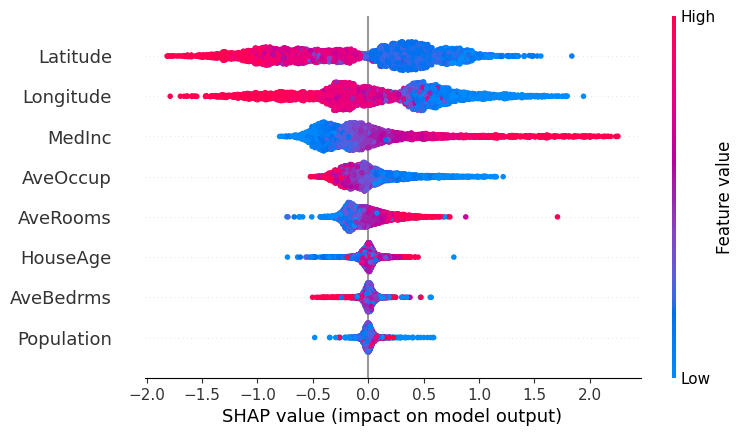

In [15]:
shap.plots.beeswarm(shap_values)
# shap.summary_plot(shap_values, X_test)

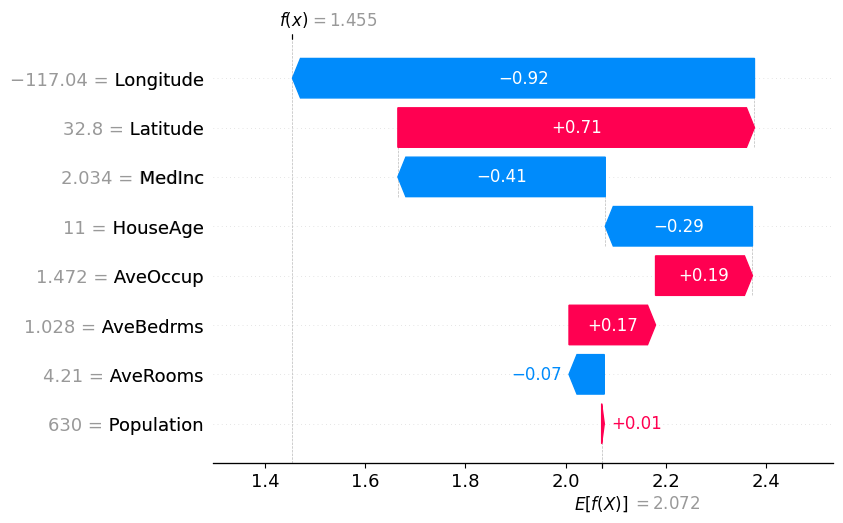

In [16]:
shap.plots.waterfall(shap_values[0])

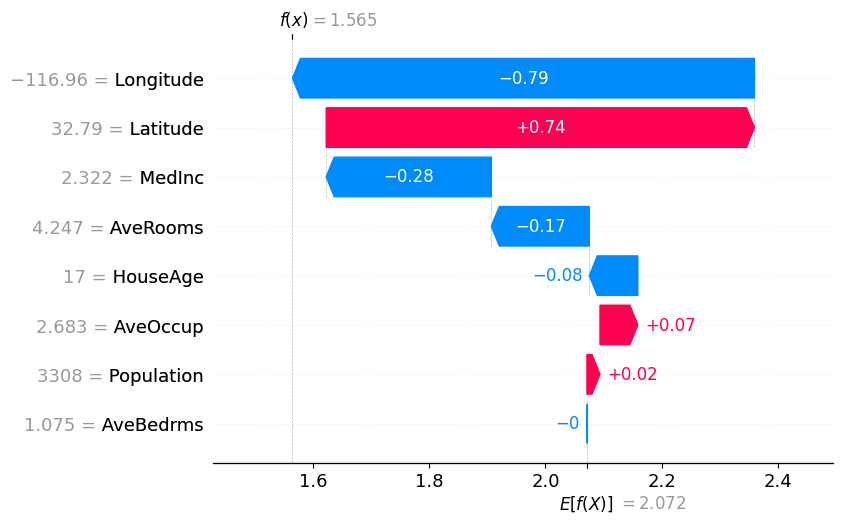

In [17]:
shap.plots.waterfall(shap_values[1])

In [18]:
shap_first_instance = shap_values[1]
shap_first_instance_values = shap_first_instance.values
print(f'Predicted value: {shap_first_instance.base_values + sum(shap_first_instance_values)}\n') # f(x) for this instance = E[f(x) + sum of all feature attributions]
print(f'Baseline: {shap_first_instance.base_values}\n') # E[f(x)] average prediction over whole test set

ordered_attr = np.argsort(-np.abs(shap_first_instance_values)) # order by descending val
for i in range(len(shap_first_instance_values)):
    print(f'{shap_values.feature_names[ordered_attr[i]]}: {shap_first_instance_values[ordered_attr[i]]}')

Predicted value: 1.5650085215456784

Baseline: 2.0718836784362793

Longitude: -0.7943982481956482
Latitude: 0.7363964319229126
MedInc: -0.283969908952713
AveRooms: -0.16846178472042084
HouseAge: -0.08339397609233856
AveOccup: 0.06505442410707474
Population: 0.022424954921007156
AveBedrms: -0.0005270498804748058


In [19]:
cal_df.head()

MedInc  HouseAge  AveRooms  AveBedrms  Population  AveOccup  Latitude  \
0  8.3252      41.0  6.984127   1.023810       322.0  2.555556     37.88   
1  8.3014      21.0  6.238137   0.971880      2401.0  2.109842     37.86   
2  7.2574      52.0  8.288136   1.073446       496.0  2.802260     37.85   
3  5.6431      52.0  5.817352   1.073059       558.0  2.547945     37.85   
4  3.8462      52.0  6.281853   1.081081       565.0  2.181467     37.85   

   Longitude  MedianHouseVal  
0    -122.23           4.526  
1    -122.22           3.585  
2    -122.24           3.521  
3    -122.25           3.413  
4    -122.25           3.422

### Check what LIME says about the same model

In [21]:
from lime import lime_tabular
predict_fn = lambda x: xgb_regressor.predict(x)

explainer = lime_tabular.LimeTabularExplainer(
    X_train,
    feature_names=cal_features,
    class_names=['MedianHouseVal'],
    verbose=True, 
    mode='regression'
    )

number_instances = 5
for i in range(number_instances):
    exp = explainer.explain_instance(
        X_test[i],
        predict_fn, num_features=number_instances
    )
    exp.show_in_notebook(show_table=True)

Intercept 2.8253468386494736
Prediction_local [2.61907223]
Right: 1.4549682


Intercept 3.016023859648902
Prediction_local [2.22426204]
Right: 1.5650119


Intercept 2.7305943890693483
Prediction_local [2.92923425]
Right: 1.6107213


Intercept 2.878711203146033
Prediction_local [2.62536427]
Right: 1.1139063


Intercept 2.783758405851011
Prediction_local [2.67399482]
Right: 3.797212


### Trying out counter factual explanations using DiCE

In [22]:
import dice_ml
from dice_ml import Dice

In [23]:
cal_df.head()


MedInc  HouseAge  AveRooms  AveBedrms  Population  AveOccup  Latitude  \
0  8.3252      41.0  6.984127   1.023810       322.0  2.555556     37.88   
1  8.3014      21.0  6.238137   0.971880      2401.0  2.109842     37.86   
2  7.2574      52.0  8.288136   1.073446       496.0  2.802260     37.85   
3  5.6431      52.0  5.817352   1.073059       558.0  2.547945     37.85   
4  3.8462      52.0  6.281853   1.081081       565.0  2.181467     37.85   

   Longitude  MedianHouseVal  
0    -122.23           4.526  
1    -122.22           3.585  
2    -122.24           3.521  
3    -122.25           3.413  
4    -122.25           3.422

In [24]:
cal_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   MedInc          20640 non-null  float64
 1   HouseAge        20640 non-null  float64
 2   AveRooms        20640 non-null  float64
 3   AveBedrms       20640 non-null  float64
 4   Population      20640 non-null  float64
 5   AveOccup        20640 non-null  float64
 6   Latitude        20640 non-null  float64
 7   Longitude       20640 non-null  float64
 8   MedianHouseVal  20640 non-null  float64
dtypes: float64(9)
memory usage: 1.4 MB


In [25]:
d_housing = dice_ml.Data(dataframe=cal_df, continuous_features=cal_features, outcome_name="MedianHouseVal")
# We provide the type of model as a parameter (model_type)
m_housing = dice_ml.Model(model=xgb_regressor, backend="sklearn", model_type='regressor')

In [26]:
exp_genetic_housing = Dice(d_housing, m_housing, method="genetic")


In [27]:
X_test_df = pd.DataFrame(X_test, columns=cal_features)

In [28]:
X_test_df

MedInc  HouseAge  AveRooms  AveBedrms  Population  AveOccup  Latitude  \
0     2.0337      11.0  4.210280   1.028037       630.0  1.471963     32.80   
1     2.3221      17.0  4.246553   1.074615      3308.0  2.682887     32.79   
2     3.7583      37.0  5.661098   1.059666      1056.0  2.520286     32.63   
3     3.6250      21.0  4.881773   1.034483       695.0  3.423645     32.69   
4     3.6375      25.0  4.238754   1.069204      1054.0  1.823529     34.16   
...      ...       ...       ...        ...         ...       ...       ...   
4123  1.9643      32.0  3.882250   1.149385      1718.0  3.019332     34.06   
4124  5.2145      28.0  6.807407   1.011111       899.0  3.329630     37.96   
4125  4.1375      16.0  6.214452   1.048951      1203.0  2.804196     35.49   
4126  2.1726      23.0  4.287179   0.987179      1060.0  2.717949     41.02   
4127  1.3962      36.0  3.766724   1.085763      2017.0  3.459691     33.93   

      Longitude  
0       -117.04  
1       -116.96  
2       -117.07  
3       -117.05  
4       -118.37  
...         ...  
4123    -117.72  
4124    -121.96  
4125    -120.69  
4126    -124.16  
4127    -118.30  

[4128 rows x 8 columns]

In [29]:
# Multiple queries can be given as input at once
query_instances_housing = X_test_df[2:4]
genetic_housing = exp_genetic_housing.generate_counterfactuals(query_instances_housing,
                                                               total_CFs=2,
                                                               desired_range=[3.0, 5.0])
genetic_housing.visualize_as_dataframe(show_only_changes=True)

100%|██████████| 2/2 [00:00<00:00,  2.69it/s]

Query instance (original outcome : 2)


MedInc  HouseAge  AveRooms  AveBedrms  Population  AveOccup   Latitude  \
0  3.7583      37.0  5.661098   1.059666      1056.0  2.520286  32.630001   

   Longitude  MedianHouseVal  
0    -117.07        1.610721


Diverse Counterfactual set (new outcome: [3.0, 5.0])


MedInc HouseAge AveRooms AveBedrms Population AveOccup Latitude Longitude  \
0  6.3434     30.0      6.0       1.1          -      2.5    33.89   -118.39   
0   4.027     31.0      4.4       1.1     1049.0      2.2    33.06    -117.3   

       MedianHouseVal  
0   4.633086681365967  
0  3.7898032665252686

Query instance (original outcome : 1)


MedInc  HouseAge  AveRooms  AveBedrms  Population  AveOccup   Latitude  \
0   3.625      21.0  4.881773   1.034483       695.0  3.423645  32.689999   

    Longitude  MedianHouseVal  
0 -117.050003        1.113906


Diverse Counterfactual set (new outcome: [3.0, 5.0])


MedInc HouseAge AveRooms AveBedrms Population AveOccup Latitude Longitude  \
0  3.5667     25.0      0.8       1.0          -      2.5    32.54    -118.4   
0  5.9499     25.0      5.1       1.0          -      2.5    33.92    -118.4   

       MedianHouseVal  
0   4.188370704650879  
0  3.2140283584594727